In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr
import downscale as down

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

## Downscaling for IMERG 3h in CONUS region

In [2]:
yy_s = 2009
yy_e = 2010

## Haversine distance

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

In [4]:
base_dir = os.path.join('/','home','arturo','github','downpy','data')

## LOAD IMERG DATA

In [41]:
data_dir = os.path.join(base_dir, 'tmpa_conus_data', 'data_tmpa_3h.hdf5')
DATA = h5py.File(data_dir, "r")
lats = DATA['lat'][:]
lons = DATA['lon'][:]

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

dates_int = DATA['dates'][:]
hours_int = DATA['hours'][:]
dates_ref = dates_int[0:len(dates_int)-1] # 2009 to 2010
hours_ref = hours_int[0:len(dates_int)-1] # 2009 to 2010

dset = np.array(DATA['prcp'])
dset[dset==np.nanmin(dset)]=0
dset = dset[:,:,0:len(dates_int)-1] # 2009 to 2010

# del DATA

In [53]:
data_dir = os.path.join(base_dir, 'tmpa_conus_data', 'data_tmpa_3h.hdf5')
DATA = h5py.File(data_dir, "r")
DATA['dates'][-1]

20110101

## Load Raingauges

In [6]:
file_list = glob.glob(os.path.join(base_dir, 'data_noaa_hpd_gauges', 'daily_csv', '*.csv'))
file_list = sorted(file_list)
len_list = len(file_list)
print(f'NUmber of files: {len_list}')

NUmber of files: 1928


In [7]:
list_names = []
for nn in range(len_list):
    tmp = file_list[nn].split('/')[-1].split('.')[0]
    list_names.append(tmp)

In [8]:
data_dir = os.path.join(base_dir, 'data_noaa_hpd_gauges', 'HOURLY_LOC_NYEARS.csv')
INFO = pd.read_csv(data_dir)

In [9]:
lo_limit_min, lo_limit_max, la_limit_min, la_limit_max = -90, -80, 30, 35

In [10]:
lat_rain = []
lon_rain = []
id_rain = []
for nn in range(len(list_names)):
    TEST = INFO[INFO['ID']==list_names[nn]]
    lat_rain.append(TEST['LAT'].values[0])
    lon_rain.append(TEST['LON'].values[0])
    id_rain.append(TEST['ID'].values[0])

lat_rain = np.array(lat_rain)
lon_rain = np.array(lon_rain)
id_rain = np.array(id_rain)


lat_bnds = np.where((lat_rain>=la_limit_min)&(lat_rain<=la_limit_max))[0]

lat_rain = lat_rain[lat_bnds]
lon_rain = lon_rain[lat_bnds]
id_rain = id_rain[lat_bnds]

lon_bnds = np.where((lon_rain>=lo_limit_min)&(lon_rain<=lo_limit_max))[0]

lat_rain = lat_rain[lon_bnds]
lon_rain = lon_rain[lon_bnds]
id_rain = id_rain[lon_bnds]

In [160]:
pos_ref = 40
pos_ref = 22

RAIN_lat = lat_rain[pos_ref]
RAIN_lon = lon_rain[pos_ref]
cid = id_rain[pos_ref]

In [174]:
input_dir = os.path.join(base_dir,'data_noaa_hpd_gauges','daily_csv',f'{cid}.csv')
RAIN = pd.read_csv(input_dir)

RAIN = RAIN[(RAIN['YEAR']>=yy_s)&(RAIN['YEAR']<=yy_e)]

RAIN=RAIN.mask(RAIN==np.min(RAIN['PRCP'])).fillna(0)

datetime_OBS = pd.to_datetime(RAIN['DATE'].values, format='%Y%m%d')

RAIN.head(3)

,Unnamed: 0,DATE,YEAR,PRCP
3221,3221,20090101,2009,0.00
3222,3222,20090102,2009,0.00
3223,3223,20090103,2009,5.08


In [176]:
OBS = xr.DataArray(RAIN['PRCP'].values,  coords={'time':datetime_OBS}, dims=('time'))
NCW, YEARS = down.fit_yearly_weibull(OBS, thresh=1, maxmiss=36)

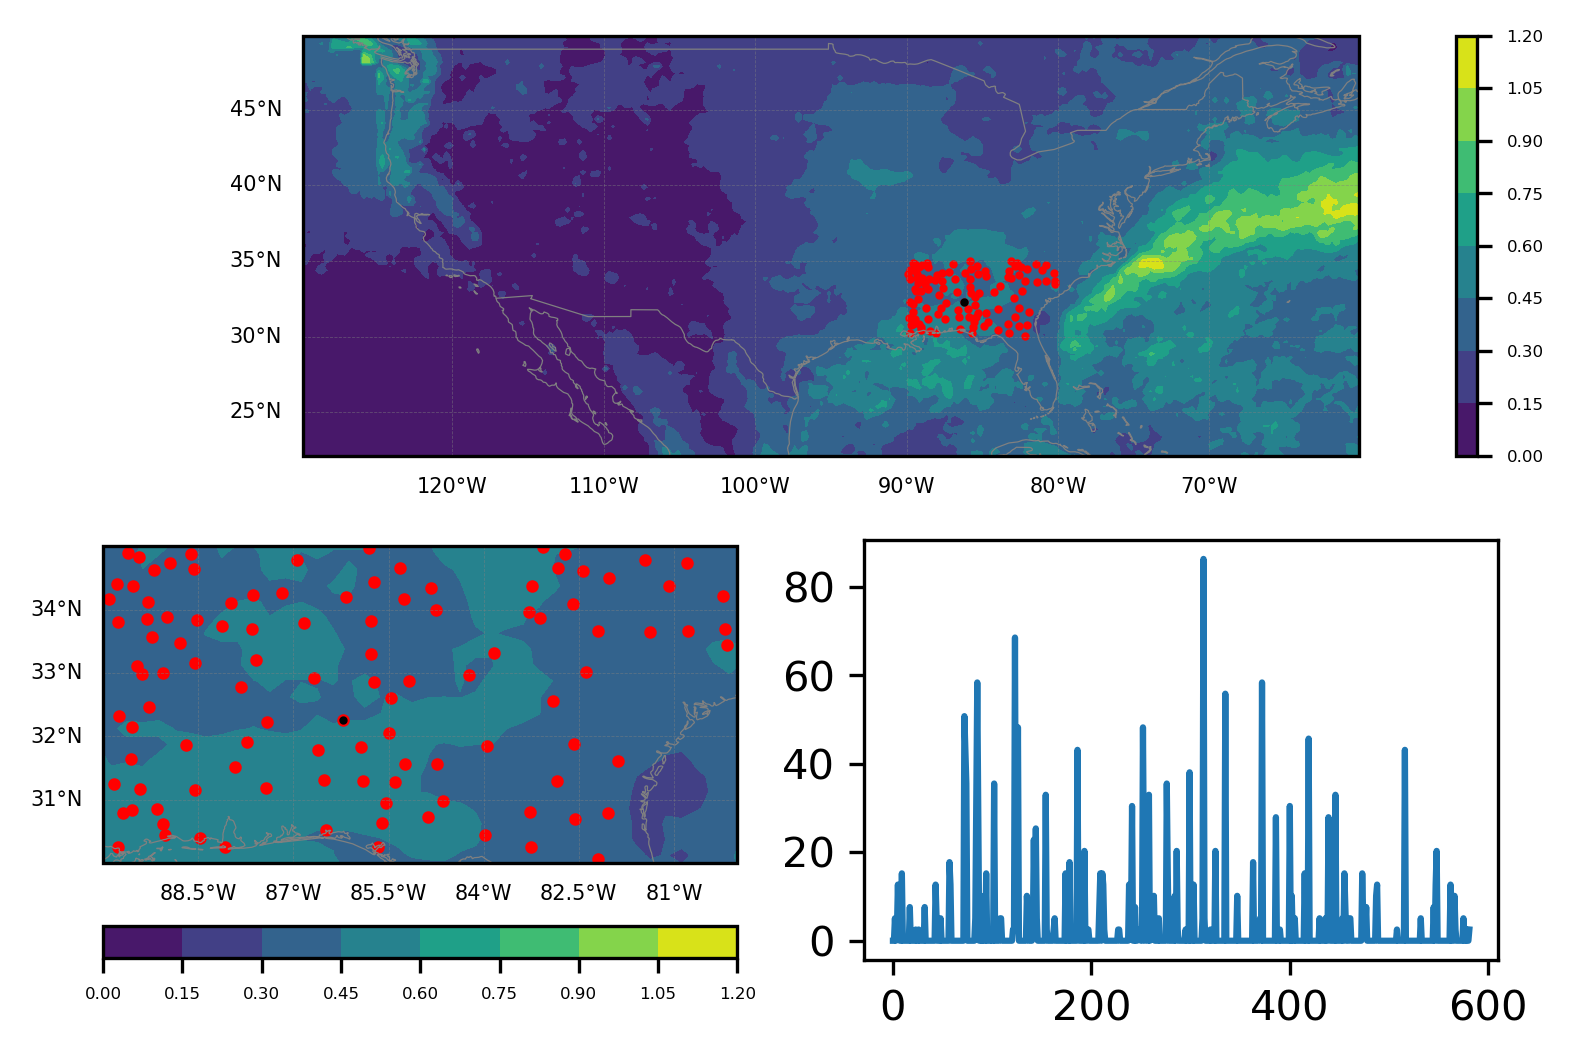

In [162]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0:], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')

a1 = ax1.contourf(lon2d, lat2d, np.nanmean(dset,axis=2).T)
ax1.scatter(lon_rain,lat_rain, s=1, c='r')
ax1.scatter(RAIN_lon, RAIN_lat, s=1, c='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='vertical', pad=0.07, fraction=0.03)
cbar.ax.tick_params(labelsize=4) 

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
ax1.set_extent([lo_limit_min, lo_limit_max, la_limit_min, la_limit_max], crs=proj)

a1 = ax1.contourf(lon2d, lat2d, np.nanmean(dset,axis=2).T)
ax1.scatter(lon_rain,lat_rain, s=4, c='r')
ax1.scatter(RAIN_lon, RAIN_lat, s=1, c='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='horizontal', pad=0.15, fraction=0.08)
cbar.ax.tick_params(labelsize=4) 

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.plot(RAIN['PRCP'].values)

In [163]:
distances = haversine(lat2d, lon2d, RAIN_lat, RAIN_lon)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

IMERG_ML = dset[:,min_index[0],min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {RAIN_lat}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {RAIN_lon}')

Nearest IMERG lat: 32.375
Station lat       : 32.26

Nearest IMERG lon: -86.125
Station lon       : -86.218


In [164]:
thresh = 1
acf = 'mar'
toll=0.005
opt_method='genetic'
# dt = 3

Tr = np.array([5, 10, 20, 50, 80, 100])
Fi = 1-1/Tr
nyears = len(Tr)

npix = 3
buffer = 0.5*npix*dx

In [165]:
datetime_str = []
for nn in range(len(hours_ref)):
    datetime_str.append(str(dates_ref[nn])+str(hours_ref[nn]))

datetime_rdy = pd.to_datetime(datetime_str, format='%Y%m%d%H')

In [167]:
xrs0 = xr.DataArray(dset,  coords={'lon':lons, 'lat':lats, 'time':datetime_rdy}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [168]:
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [169]:
box_3h = xrs.where(bcond, drop = True).load()
box_3h = box_3h.resample(time ='D').sum(dim='time', skipna=False)
box_3h.shape

(3, 3, 389)

In [170]:
downres = down.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, toll=0.005,
                            acf='mar', save_yearly=True,
                            maxmiss=100, clat=clat, clon=clon,
                            opt_method='genetic', plot=True) #maxmiss=36

Downscaling Intermittency
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.006414430313410817
differential_evolution step 2: f(x)= 0.006414430313410817
differential_evolution step 3: f(x)= 0.006125249607167274
differential_evolution step 4: f(x)= 0.006125249607167274
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


In [131]:
downres

{'NYs': array([58.]),
 'CYs': array([11.29966591]),
 'WYs': array([0.71825701]),
 'NYd': array([69.]),
 'CYd': array([6.32327181]),
 'WYd': array([0.52062553]),
 'Tr': array([  5,  10,  20,  50,  80, 100]),
 'mev_d': array([182.13558091, 230.33046039, 281.68457627, 355.5260886 ,
        396.23808226, 416.26006959]),
 'mev_s': array([124.21217921, 147.91920412, 171.74183661, 204.03191496,
        221.04374094, 229.23434789]),
 'gam_d': 0.6418428252594159,
 'gam_s': 0.9375924217552394,
 'beta': 0.8427600757184567,
 'Nd': 69.0,
 'Cd': 6.184797265153635,
 'Wd': 0.5190928408558343,
 'Ns': 58,
 'Cs': 11.065551536552022,
 'Ws': 0.7152135788205972,
 'eps_s': 191.61477886955643,
 'alp_s': 0.946750408893836,
 'eps_d': 2.0130480826005024,
 'alp_d': 0.1646471924857077,
 'corr_down_success': True,
 'corr_down_funval': 0.00017348538223308874,
 'w_down_funval': 2.362554596402333e-13,
 'thresh': 1.0,
 'clat': 34.875,
 'clon': -98.125,
 'corr_plot': <Figure size 640x480 with 1 Axes>,
 'Taylor_contour':

In [178]:
NCW, YEARS

(array([[91.        , 12.29979146,  0.7851097 ]]), array([2009.]))